## TUIA - Aprendizaje Automático 1

### Trabajo Práctico: Predicción de lluvia en Australia.

### Integrantes:
- Ponce, Daniel
- Yañez, Mirian



El presente informe detalla el trabajo práctico llevado a cabo para la predicción de las condiciones climáticas en Australia, centrándonos en las ciudades de Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport. 

El conjunto de datos utilizado se denomina weatherAUS.csv y contiene información climática de los últimos diez años.

## Variables de Interés:

**RainTomorrow y RainfallTomorrow**: Estas variables representan nuestro objetivo de predicción, indicando si lloverá al día siguiente y la cantidad de lluvia, respectivamente.

"RainTomorrow" (categórica, para un problema de clasificación)

"RainfallTomorrow" (continua, para un problema de regresión).

## Paquetes y Librerias

In [1]:
!pip3 install pandas scikit-learn seaborn imblearn
!pip3 install -U imbalanced-learn



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression, ElasticNetCV, RidgeCV
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score, roc_auc_score, roc_curve, mean_squared_error, r2_score, mean_absolute_error
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
import shap
import warnings
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
warnings.filterwarnings("ignore")

2024-06-20 14:49:45.120774: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Función que vamos a utilizar más adelante para las métricas de regresión

In [3]:
def show_metrics_regresion(y, y_pred, title, nr_neuronal=True):
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    print(title)
    print("Mean Squared Error :", mse)
    print("R-squared:", r2)
    print("Mean Absolute Error (MAE):", mae)
    if nr_neuronal:
        mape = np.mean(np.abs((y - y_pred) / y)) * 100
        print("Mean Absolute Percentage Error (MAPE):", mape)

### Función para metricas adicionales de clasificación 

In [4]:
def show_metrics_extras(y, y_pred, title=''):
    balanced_accuracy = balanced_accuracy_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    specificity = tn / (tn + fp)
    mcc = matthews_corrcoef(y, y_pred)
    kappa = cohen_kappa_score(y, y_pred)
    print(title)
    print(f'Especificidad: {specificity}')
    print("Precisión Balanceada:", balanced_accuracy)
    print("Coeficiente de Correlación de Matthews:", mcc)
    print("Kappa: ",kappa)

### Especificidad:

La especificidad, también conocida como tasa de verdaderos negativos (TNR), mide la proporción de casos negativos reales que se identifican correctamente como negativos. Se calcula como el número de verdaderos negativos (TN) dividido por el número total de negativos (TN + FP).

En otras palabras, la especificidad indica qué tan bien el modelo evita clasificar erróneamente las instancias negativas como positivas. Un valor de especificidad alto (cercano a 1) significa que el modelo es muy bueno para distinguir entre verdaderos negativos y falsos positivos.

### Precisión Balanceada:

La precisión balanceada, también conocida como precisión equilibrada, es una métrica diseñada específicamente para evaluar modelos de clasificación en conjuntos de datos desequilibrados. Tiene en cuenta el desequilibrio entre las clases positivas y negativas, proporcionando una evaluación más equilibrada del rendimiento del modelo.

La precisión balanceada se calcula como el promedio de la sensibilidad y la especificidad, dando el mismo peso a ambas medidas. Esto es importante en conjuntos de datos desequilibrados donde centrarse únicamente en la precisión puede ser engañoso, ya que se puede lograr una alta precisión simplemente prediciendo la clase mayoritaria (incluso si eso significa clasificar incorrectamente muchas instancias de la clase minoritaria).

### Coeficiente de Correlación de Matthews (MCC):

El coeficiente de correlación de Matthews (MCC) es una métrica completa que considera tanto los verdaderos positivos como los verdaderos negativos, proporcionando una evaluación más robusta del rendimiento de la clasificación. Se calcula como el coeficiente de correlación entre las etiquetas de clase binarias predichas y reales.

MCC varía de -1 a 1, donde 1 indica una concordancia perfecta entre las etiquetas predichas y reales, 0 indica que no hay correlación y -1 indica una discordancia completa. Un valor MCC más alto (más cercano a 1) indica un mejor rendimiento.

### Kappa:

Kappa, también conocido como kappa de Cohen, es una medida estadística de concordancia entre dos anotadores o clasificaciones. Tiene en cuenta la posibilidad de concordancia aleatoria, proporcionando una evaluación de concordancia más matizada que simplemente comparar el porcentaje de etiquetas coincidentes.

Kappa varía de 0 a 1, donde 1 indica una concordancia perfecta, 0 indica que no hay concordancia más allá del azar y los valores negativos indican una concordancia peor que el azar. Un valor kappa más alto (más cercano a 1) indica una mejor concordancia entre las etiquetas predichas y reales.

## Importamos el dataset

In [5]:
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',')

## Filtramos por las ciudades de interés, convertimos a formato date la fecha y las ordenamos de forma ascendente


In [6]:
ciudades = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']
df = df[df['Location'].isin(ciudades)]
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

## Visualizamos la distribución de los datos por año

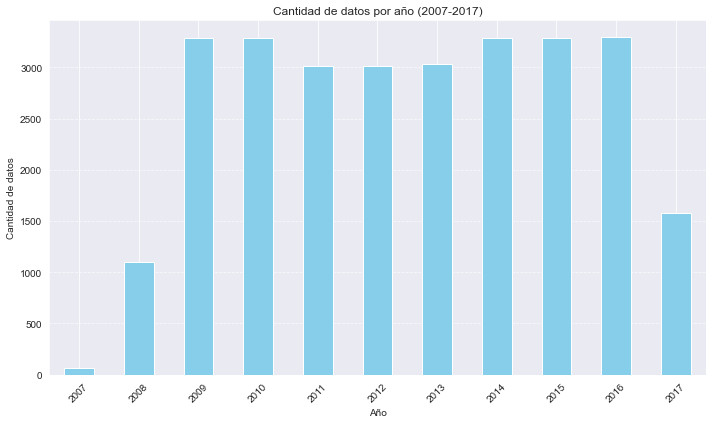

In [7]:
df['Year'] = pd.to_datetime(df['Date']).dt.year # Creamos la columna Year para poder realizar la visualización por año

# Contamos la cantidad de datos por año
data_by_year = df['Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
data_by_year.plot(kind='bar', color='skyblue')
plt.title('Cantidad de datos por año (2007-2017)')
plt.xlabel('Año')
plt.ylabel('Cantidad de datos')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
df = df.drop(columns=['Year']) # Eliminamos la columna Year

## Realizamos el split de entrenamiento y prueba 

Decidimos dividir el conjunto de datos de forma manual. Esta elección se debe a que posteriormente imputaremos los valores basados en la fecha. Si utilizáramos la función train_test_split, la separación sería aleatoria, lo que podría provocar una fuga de datos.


In [8]:
# Definimos las fechas límite para la división
date_train_limit = pd.to_datetime('2015-10-06')

# Filtramos el DataFrame para obtener los conjuntos de entrenamiento y prueba
train = df[df['Date'] <= date_train_limit]
test = df[df['Date'] > date_train_limit]

print(f"El conjunto de entrenamiento tiene {len(train)} registros y va hasta la fecha {date_train_limit}.")
print(f"El conjunto de prueba tiene {len(test)} registros y empieza a partir de la fecha {date_train_limit}.")

El conjunto de entrenamiento tiene 22590 registros y va hasta la fecha 2015-10-06 00:00:00.
El conjunto de prueba tiene 5643 registros y empieza a partir de la fecha 2015-10-06 00:00:00.


## Análisis descriptivo

Se realizará un análisis exploratorio del conjunto de datos de entrenamiento para entender sus características principales y determinar si se requiere alguna acción para abordar datos faltantes, valores atípicos, la codificación de variables categóricas u otros procesos antes de proceder.

In [9]:
train.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [10]:
train.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
45573,45587,2007-11-01,Canberra,8.0,24.3,0.0,3.4,6.3,NW,30.0,...,29.0,1019.7,1015.0,7.0,7.0,14.4,23.6,No,Yes,3.6
45574,45588,2007-11-02,Canberra,14.0,26.9,3.6,4.4,9.7,ENE,39.0,...,36.0,1012.4,1008.4,5.0,3.0,17.5,25.7,Yes,Yes,3.6
45575,45589,2007-11-03,Canberra,13.7,23.4,3.6,5.8,3.3,NW,85.0,...,69.0,1009.5,1007.2,8.0,7.0,15.4,20.2,Yes,Yes,39.8
45576,45590,2007-11-04,Canberra,13.3,15.5,39.8,7.2,9.1,NW,54.0,...,56.0,1005.5,1007.0,2.0,7.0,13.5,14.1,Yes,Yes,2.8
45577,45591,2007-11-05,Canberra,7.6,16.1,2.8,5.6,10.6,SSE,50.0,...,49.0,1018.3,1018.5,7.0,7.0,11.1,15.4,Yes,No,0.0


In [11]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22590 entries, 45573 to 83352
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        22590 non-null  int64         
 1   Date              22590 non-null  datetime64[ns]
 2   Location          22590 non-null  object        
 3   MinTemp           22233 non-null  float64       
 4   MaxTemp           22246 non-null  float64       
 5   Rainfall          21848 non-null  float64       
 6   Evaporation       20574 non-null  float64       
 7   Sunshine          18628 non-null  float64       
 8   WindGustDir       21019 non-null  object        
 9   WindGustSpeed     21022 non-null  float64       
 10  WindDir9am        21175 non-null  object        
 11  WindDir3pm        22176 non-null  object        
 12  WindSpeed9am      22240 non-null  float64       
 13  WindSpeed3pm      22254 non-null  float64       
 14  Humidity9am       

Unnamed: 0             0
Date                   0
Location               0
MinTemp              357
MaxTemp              344
Rainfall             742
Evaporation         2016
Sunshine            3962
WindGustDir         1571
WindGustSpeed       1568
WindDir9am          1415
WindDir3pm           414
WindSpeed9am         350
WindSpeed3pm         336
Humidity9am          605
Humidity3pm          561
Pressure9am          625
Pressure3pm          618
Cloud9am            7179
Cloud3pm            7469
Temp9am              372
Temp3pm              366
RainToday            742
RainTomorrow         742
RainfallTomorrow     742
dtype: int64

### **Hay un total de 22590 datos de entrenamiento, 25 columnas y se puede observar que hay datos nulos en la mayoria de las variables.**

### Eliminamos la columna 'Unnamed: 0' y 'Location'
Eliminamos la columna Location ya que vamos a considerarlas a todas como una sola

In [12]:
train = train.drop(columns=['Unnamed: 0', 'Location'])

### Cambiamos los valores nulos
Debido a que tomamos las ciudades como una única localidad, decidimos reemplazar los valores faltantes por otro de la misma fecha o, en su defecto, por la más cercana.

In [13]:
train.sort_values(by='Date', inplace=True)
train.fillna(method='ffill', inplace=True)

In [14]:
train.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

### Eliminamos la columna Date:
La razon es que ya no la vamos a usar, solo la usamos como criterio para el reemplazo de los valores nulos

In [15]:
train = train.drop(columns=['Date'])

In [16]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

## Creación de columnas 
Con el objetivo de reducir la cantidad de columnas y mejorar la explicabilidad del modelo, decidimos agrupar las variables que representan dos momentos del día en una sola columna.

In [17]:
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
train['PressureVariation'] = train['Pressure3pm'] - train['Pressure9am']
train['TempVariation'] = train['Temp3pm'] - train['Temp9am']
train['HumidityVariation'] = train['Humidity3pm'] - train['Humidity9am']
train['CloudVariation'] = train['Cloud3pm'] - train['Cloud9am']
train['WindSpeedVariation'] = train['WindSpeed3pm'] - train['WindSpeed9am']
train.drop(columns=columns_to_aggregate, inplace=True)


In [18]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow', 'RainfallTomorrow', 'PressureVariation',
       'TempVariation', 'HumidityVariation', 'CloudVariation',
       'WindSpeedVariation'],
      dtype='object')

### Estadística descriptiva de las variables numéricas
Examinamos medidas estadísticas, incluyendo valores mínimos, máximos, cuartiles, y medidas de centralidad como la mediana (50%) y la media.

In [19]:
train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,RainfallTomorrow,PressureVariation,TempVariation,HumidityVariation,CloudVariation,WindSpeedVariation
count,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000,22590.000000
mean,11.061669,21.624812,2.031921,4.676733,6.858752,42.163612,2.024914,-2.102975,4.910801,-18.345418,0.128862,4.876184
std,5.693569,6.603190,6.398745,3.595545,3.853037,14.317466,6.337360,2.111616,3.420125,15.748060,2.610961,9.062311
min,-8.000000,4.100000,0.000000,0.000000,0.000000,11.000000,0.000000,-13.800000,-10.200000,-89.000000,-8.000000,-46.000000
25%,7.300000,16.400000,0.000000,2.200000,3.800000,31.000000,0.000000,-3.500000,2.600000,-28.000000,-1.000000,0.000000
50%,10.700000,20.700000,0.000000,4.000000,7.300000,41.000000,0.000000,-2.300000,4.600000,-18.000000,0.000000,5.000000
75%,14.900000,25.800000,1.000000,6.400000,10.000000,50.000000,1.000000,-0.900000,7.100000,-9.000000,1.000000,11.000000
max,33.900000,46.800000,119.400000,64.800000,14.300000,122.000000,119.400000,20.400000,23.000000,76.000000,8.000000,52.000000


Al analizar las columnas, se percibe que tanto la media como la mediana muestran una cercanía notable, lo que sugiere una tendencia consistente en los datos. Los desvíos en la dispersión de los datos no son extremos y la distribución no presentaria una gran extensión en un boxplot.

Los valores mínimos y máximos registrados estan considerablemente alejados de los valores centrales, lo cual señala la posible existencia de valores atípicos dentro del conjunto de datos.

## **Bloxplot**

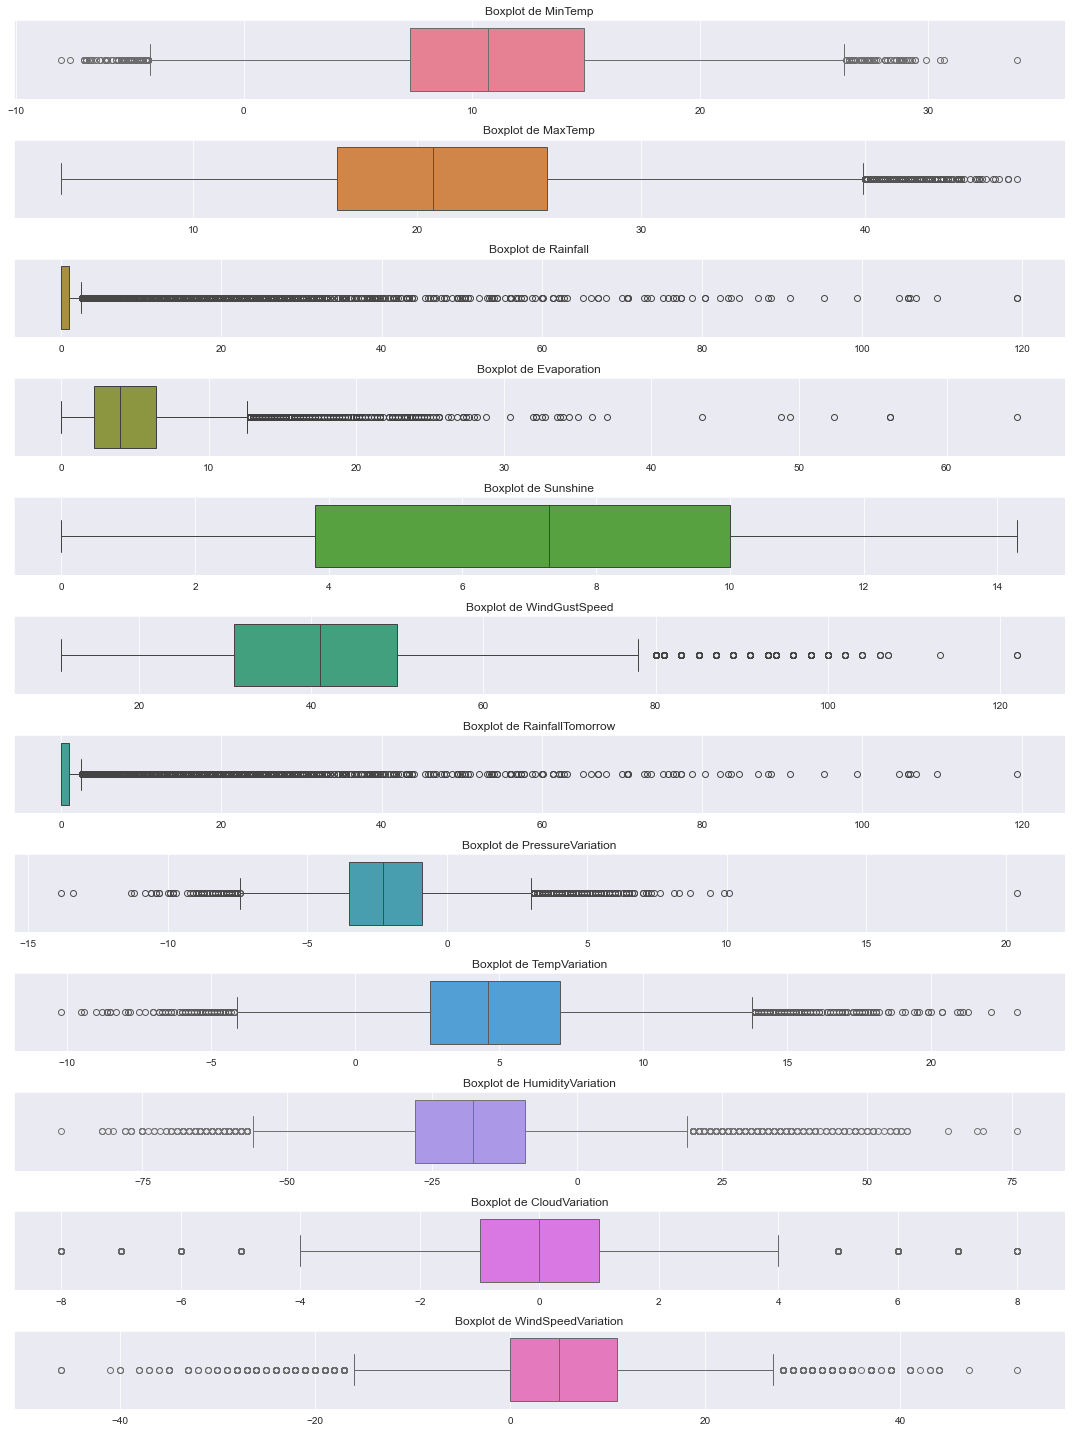

In [20]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

colores = sns.color_palette('husl', n_colors=len(numeric_columns))

fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(15, 20), sharex=False)

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=train, x=col, ax=axes[i], color=colores[i], orient='h')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('')

plt.tight_layout()

plt.show()

Se puede observar una gran presencia de valores que parecen ser atípicos en la mayoría de las variables

## Histograma

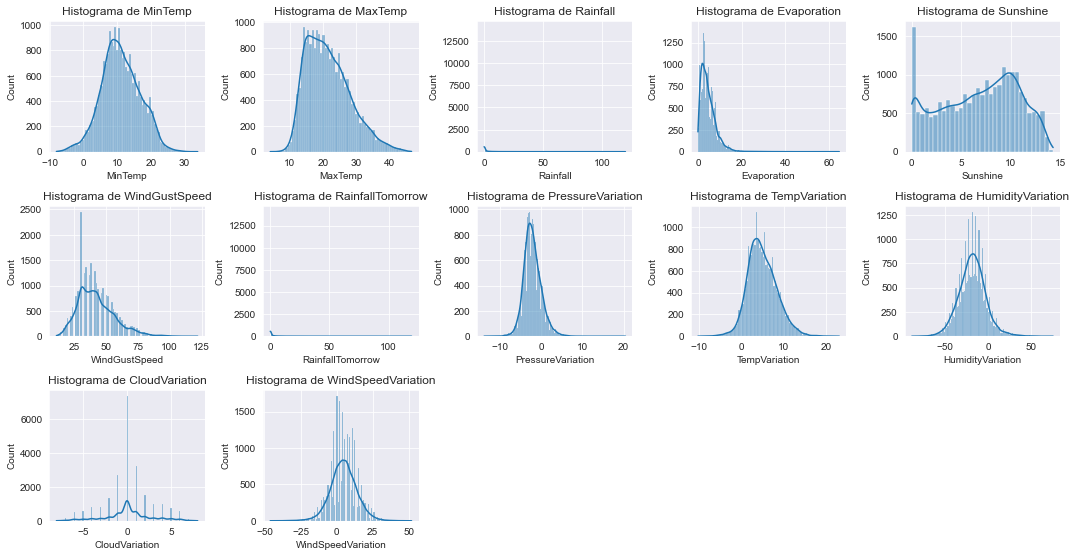

In [21]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(train[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()

Para comprender más a fondo el comportamiento de los datos, empleamos histogramas donde se puede apreciar que algunas variables exhiben una distribución más uniforme de sus valores, como es el caso de la temperatura, humedad y presión. Por otro lado, existen variables que muestran la presencia de múltiples modas en los datos y una distribución menos uniforme.

Asimismo, se destaca que la variable Rainfall concentra la gran mayoría de sus datos en cero.

## Analizamos nuestra variable objetivo, la que queremos predecir para saber si el dataset esta balanceado o no.
Primero convertimos las variables categóricas en numéricas

In [22]:
train['RainToday'] = train['RainToday'].map({'No': 0, 'Yes': 1})
train['RainTomorrow'] = train['RainTomorrow'].map({'No': 0, 'Yes': 1})

test['RainToday'] = test['RainToday'].map({'No': 0, 'Yes': 1})
test['RainTomorrow'] = test['RainTomorrow'].map({'No': 0, 'Yes': 1})

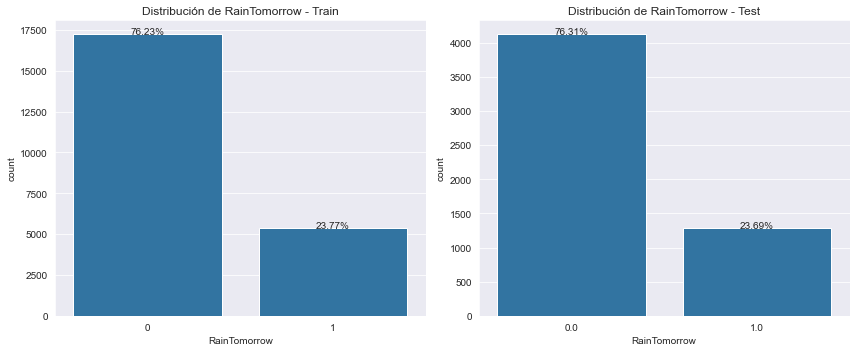

In [23]:
# Calculamos los porcentajes para el conjunto de entrenamiento
train_percentages = train['RainTomorrow'].value_counts(normalize=True) * 100
# Calculamos los porcentajes para el conjunto de prueba
test_percentages = test['RainTomorrow'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='RainTomorrow', data=train)
plt.title('Distribución de RainTomorrow - Train')
for i, value in enumerate(train_percentages):
    plt.text(i, train['RainTomorrow'].value_counts()[i], f'{value:.2f}%', ha='center')

plt.subplot(1, 2, 2)
sns.countplot(x='RainTomorrow', data=test)
plt.title('Distribución de RainTomorrow - Test')
for i, value in enumerate(test_percentages):
    plt.text(i, test['RainTomorrow'].value_counts()[i], f'{value:.2f}%', ha='center')

plt.tight_layout()
plt.show()


Se observa que tanto en el conjuntos de entrenamiento como en el de prueba hay una mayor cantidad de datos donde no llueve (0) comparado con los días que llueve (1). Esto puede hacer que el modelo tenga un sesgo muy importante al momento de predecir. Por esta razón, podemos decir que los datos no se encuentran balanceados.

Podemos ver una relacion 3 a 1 aproximadamente, en este caso existe la posibilidad de balancear el dataset.

# Matriz de correlación 

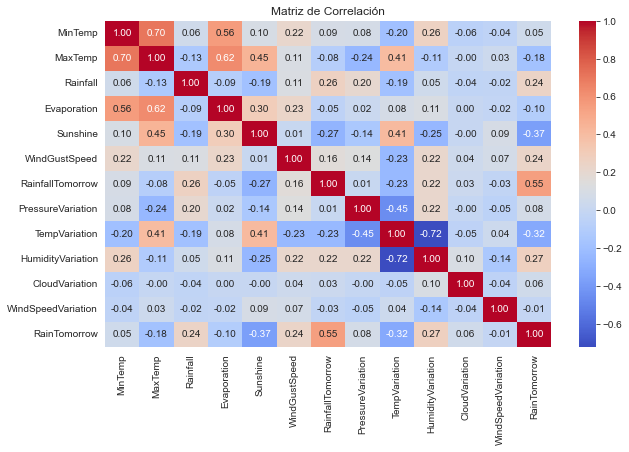

In [24]:
numeric_columns = numeric_columns.append(pd.Index(['RainTomorrow']))
correlation_matrix_numeric = train[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Podemos observar que las variables con mayor correlación positiva con RainfallTomorrow son:

*   Rainfall (0.25)
*   HumidityVariation (0.22)
*   WindGustSpeed (0.17)

Las variables con mayor correlación negativa con RainfallTomorrow son:
*   Sunshine (-0.28)
*   TempVariation (-0.23)

Las variables con mayor correlación positiva con RainTomorrow son:

*   RainfallTomorrow (0.55)
*   HumidityVariation (0,27)
*   Rainfall (0.24)
*   WindGustSpeed (0,24)

Las variables con mayor correlación negativa con RainTomorrow son:
*   Sunshine (-0.37)
*   TempVariation (-0.32)

## Para poder ver las metricas de test necesitamos aplicarle los mismos cambios que se hicieron en train.

In [25]:
test.sort_values(by='Date', inplace=True)

for column in test.columns:
    test[column] = test[column].ffill()
    test[column] = test[column].bfill() 
    
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
test = test.drop(columns=['Unnamed: 0', 'Location','Date'])
test['PressureVariation'] = test['Pressure3pm'] - test['Pressure9am']
test['TempVariation'] = test['Temp3pm'] - test['Temp9am']
test['HumidityVariation'] = test['Humidity3pm'] - test['Humidity9am']
test['CloudVariation'] = test['Cloud3pm'] - test['Cloud9am']
test['WindSpeedVariation'] = test['WindSpeed3pm'] - test['WindSpeed9am']
test.drop(columns=columns_to_aggregate, inplace=True)


# Método LinearRegression

Evaluamos el modelo con los datos de entrenamiento y luego con los de test

In [26]:
X_train = train.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_train = train['RainfallTomorrow']
X_test = test.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_test = test['RainfallTomorrow']
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")

Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.194637493217684
R-squared: 0.17344762532096447
Mean Absolute Error (MAE): 2.716306730234828
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.12970897845244
R-squared: 0.19087344363865166
Mean Absolute Error (MAE): 2.8544855627909236
Mean Absolute Percentage Error (MAPE): inf


No se observa presencia de overfiting, podemos notar que las metricas de train y test son bastante similares

El modelo de regresión lineal tiene un bajo rendimiento, con un R² alrededor de 0.17-0.19, indicando que no explica bien la variabilidad de los datos. 

Las métricas de error (MSE y MAE) son ligeramente mayores en los datos de prueba que en los de entrenamiento, sugiriendo una generalización razonable pero mejorable. 

El MAPE no es fiable debido a valores pequeños en la variable dependiente

# Método de gradiente descendiente

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Evitar divisiones por cero
    y_true = np.where(y_true == 0, 1e-7, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def gradient_descent(X_train, y_train, X_test, y_test, lr, epochs):
    n = X_train.shape[0]
    m = X_train.shape[1]
    o = X_test.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((o, 1)), X_test))

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for i in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W)
        error_train = y_train - prediction_train
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_test, W)
        error_test = y_test - prediction_test
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Calcular métricas finales para entrenamiento y prueba
    y_pred_train = np.matmul(X_train, W)
    y_pred_test = np.matmul(X_test, W)

    train_mse = mean_squared_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_mape = mean_absolute_percentage_error(y_train, y_pred_train)

    test_mse = mean_squared_error(y_test, y_pred_test)
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mape = mean_absolute_percentage_error(y_test, y_pred_test)

    print("Métricas sobre los datos de entrenamiento:")
    print(f"Mean Squared Error (MSE): {train_mse}")
    print(f"R-squared: {train_r2}")
    print(f"Mean Absolute Error (MAE): {train_mae}")
    print(f"Mean Absolute Percentage Error (MAPE): {train_mape}")

    print("Métricas sobre los datos de prueba:")
    print(f"Mean Squared Error (MSE): {test_mse}")
    print(f"R-squared: {test_r2}")
    print(f"Mean Absolute Error (MAE): {test_mae}")
    print(f"Mean Absolute Percentage Error (MAPE): {test_mape}")

    # Graficar errores de entrenamiento y prueba
    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de test')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (GD)')
    plt.show()

    return


In [28]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1,1))

X_train_scaled1=scaler.fit_transform(X_train)
X_test_scaled1=scaler.transform(X_test)

y_train_scaled1 = scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled1 = scaler.fit_transform(y_test.values.reshape(-1,1))

Métricas sobre los datos de entrenamiento:
Mean Squared Error (MSE): 33.281515335139694
R-squared: 0.17128435161260414
Mean Absolute Error (MAE): 2.669294718965365
Mean Absolute Percentage Error (MAPE): 977414876.350411
Métricas sobre los datos de prueba:
Mean Squared Error (MSE): 58.061026259624086
R-squared: 0.16782114992581554
Mean Absolute Error (MAE): 3.212349678688237
Mean Absolute Percentage Error (MAPE): 963194365.7762802


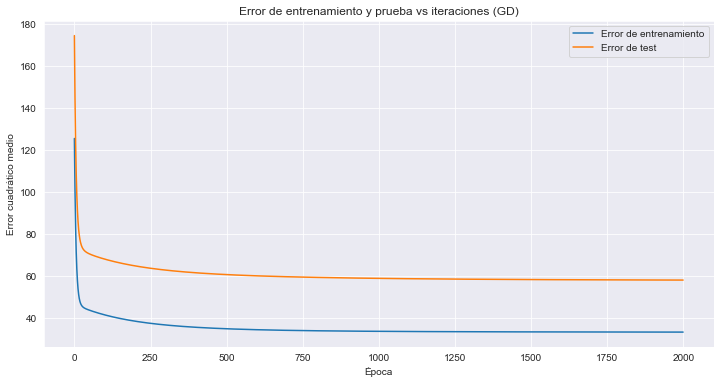

In [29]:
gradient_descent(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lr=0.001, epochs=2000)

Con Gradiente Descendiente, el MSE de prueba coincide con el de la regresión lineal en la predicción. Requiere 2000 iteraciones para lograrlo, utilizando una tasa de aprendizaje de 0.001.

# Métodos de regularización Lasso

In [30]:
# Crear y entrenar el modelo Lasso
lasso_model = Lasso(alpha=0.1)  # alpha es el parámetro de regularización
lasso_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")


Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.28781103361508
R-squared: 0.17112758760136426
Mean Absolute Error (MAE): 2.690311813048576
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.23323246587551
R-squared: 0.18855503019859043
Mean Absolute Error (MAE): 2.8367531886357638
Mean Absolute Percentage Error (MAPE): inf


## Lasso con grid_search con CV

In [31]:
# Define los valores de los hiperparámetros que quieres explorar
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]  # Lista de valores para alpha
}
lasso_model = Lasso()
grid_search = GridSearchCV(estimator=lasso_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada

grid_search.fit(X_train, y_train)
print("Mejores hiperparámetros encontrados:{}".format(grid_search.best_params_))
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_gs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_gs, "Métricas sobre los datos de prueba:")


Mejores hiperparámetros encontrados:{'alpha': 0.1}
Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.28781103361508
R-squared: 0.17112758760136426
Mean Absolute Error (MAE): 2.690311813048576
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.23323246587551
R-squared: 0.18855503019859043
Mean Absolute Error (MAE): 2.8367531886357638
Mean Absolute Percentage Error (MAPE): inf


# Regresión de Ridge

In [32]:
ridge_model = Ridge(alpha=0.1)  # alpha es el parámetro de regularización
ridge_model.fit(X_train, y_train)
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")


Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.194637493390175
R-squared: 0.17344762531666946
Mean Absolute Error (MAE): 2.7163058016230766
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.12970805721611
R-squared: 0.19087346426978336
Mean Absolute Error (MAE): 2.854484774754714
Mean Absolute Percentage Error (MAPE): inf


## Ridge con grid_search

In [33]:
inicio = 0.01
fin = 10.0
paso = 0.01

alphas = [inicio + i * paso for i in range(int((fin - inicio) / paso) + 1)]
param_grid = {
    'alpha': alphas
}
ridge_model = Ridge()
grid_search = GridSearchCV(estimator=ridge_model, 
                           param_grid=param_grid, 
                           scoring='neg_mean_squared_error',  # Métrica de evaluación
                           cv=5)  # Número de divisiones de validación cruzada
grid_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{grid_search.best_params_}")
y_pred_train_gs = grid_search.predict(X_train)
y_pred_test_gs = grid_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_gs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_gs, "Métricas sobre los datos de prueba:")


Mejores hiperparámetros encontrados:{'alpha': 10.0}
Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.1946392042242
R-squared: 0.17344758271659788
Mean Absolute Error (MAE): 2.7162144719744723
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.12961920230957
R-squared: 0.19087545417965446
Mean Absolute Error (MAE): 2.8544074644115818
Mean Absolute Percentage Error (MAPE): inf


## Método de regularización Elasticnet

In [34]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha es el parámetro de regularización, l1_ratio controla la proporción de L1 y L2
elastic_net_model.fit(X_train, y_train)
y_pred_train = elastic_net_model.predict(X_train)
y_pred_test = elastic_net_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test, "Métricas sobre los datos de prueba:")

Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.23784031037303
R-squared: 0.17237186749351796
Mean Absolute Error (MAE): 2.6976442125035636
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.17786288109412
R-squared: 0.18979503469151449
Mean Absolute Error (MAE): 2.840671832498086
Mean Absolute Percentage Error (MAPE): inf


## Elasticnet con validación cruzada

In [35]:
alphas = [0.001, 0.1, 0.3, 0.5, 0.8, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
l1_ratios = [0.1, 0.5, 0.9]
elastic_net_cv_model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios)
elastic_net_cv_model.fit(X_train, y_train)
y_pred_train_cv = elastic_net_cv_model.predict(X_train)
y_pred_test_cv = elastic_net_cv_model.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_cv, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_cv, "Métricas sobre los datos de prueba:")


Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.194646141407745
R-squared: 0.17344740997949448
Mean Absolute Error (MAE): 2.7160843891255624
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.129542400044436
R-squared: 0.19087717417004668
Mean Absolute Error (MAE): 2.8542995997821987
Mean Absolute Percentage Error (MAPE): inf


## Elasticnet con random_search

In [36]:
param_distributions = {
    'alpha': uniform(0.01, 10.0),  # Rango uniforme entre 0.1 y 10.0 para alpha
    'l1_ratio': uniform(0, 1),     # Rango uniforme entre 0 y 1 para l1_ratio
}
elastic_net_model = ElasticNet()
random_search = RandomizedSearchCV(estimator=elastic_net_model, 
                                   param_distributions=param_distributions, 
                                   n_iter=100,  # Número de iteraciones de búsqueda aleatoria
                                   scoring='neg_mean_squared_error',  # Métrica de evaluación
                                   cv=5,  # Número de divisiones de validación cruzada
                                   random_state=42)

random_search.fit(X_train, y_train)
print(f"Mejores hiperparámetros encontrados:{random_search.best_params_}")
y_pred_train_rs = random_search.predict(X_train)
y_pred_test_rs = random_search.predict(X_test)
show_metrics_regresion(y_train, y_pred_train_rs, "Métricas sobre los datos de entrenamiento:")
show_metrics_regresion(y_test, y_pred_test_rs, "Métricas sobre los datos de prueba:")


Mejores hiperparámetros encontrados:{'alpha': 0.07952130531190703, 'l1_ratio': 0.5107473025775657}
Métricas sobre los datos de entrenamiento:
Mean Squared Error : 33.22596412399588
R-squared: 0.1726675866455698
Mean Absolute Error (MAE): 2.7002123497854367
Mean Absolute Percentage Error (MAPE): inf
Métricas sobre los datos de prueba:
Mean Squared Error : 36.163855139723786
R-squared: 0.19010873872782819
Mean Absolute Error (MAE): 2.842414000587958
Mean Absolute Percentage Error (MAPE): inf


### Regresión Lineal (Simple)
No requiere optimización de hiperparámetros.
La regresión lineal simple no tiene hiperparámetros que necesiten ajuste.
### Ridge Regression (Regresión Ridge)
Método de búsqueda sugerido: Grid Search
Ridge Regression solo tiene un hiperparámetro principal (alpha), que controla la regularización. Dado que el espacio de búsqueda es unidimensional y generalmente pequeño, Grid Search es eficiente y suficientemente exhaustivo para encontrar el mejor valor de alpha.
### Lasso Regression (Regresión Lasso)
Método de búsqueda sugerido: Grid Search
Similar a Ridge Regression, Lasso tiene un único hiperparámetro (alpha). Grid Search es adecuado porque permite una búsqueda exhaustiva en un espacio de búsqueda unidimensional.

### Elastic Net
Método de búsqueda sugerido: Random Search
Elastic Net tiene dos hiperparámetros (alpha y l1_ratio). El espacio de búsqueda es bidimensional y potencialmente grande. Random Search es más eficiente en este caso porque puede explorar un mayor número de combinaciones de hiperparámetros en menos tiempo en comparación con Grid Search.

### Con respecto a las métricas, elegimos el r2 para comparar los distintos modelos
### Necesitamos comparar los resultados obtenidos tanto en entrenamiento como en prueba para poder determinar si nuestro modelo esta ajustando correctamente.


# Regresión Logística para clasificación

### Definimos las variables para clasificación

In [37]:
y_train_clasification =train['RainTomorrow']
y_test_clasification = test['RainTomorrow']

Metricas extras En Entrenamiento
Especificidad: 0.939198606271777
Precisión Balanceada: 0.6881281671954789
Coeficiente de Correlación de Matthews: 0.44825613989392316
Kappa:  0.4307998900494777
Metricas extras En Test
Especificidad: 0.9512138728323699
Precisión Balanceada: 0.6516312156271106
Coeficiente de Correlación de Matthews: 0.39539092157686256
Kappa:  0.365198196425363


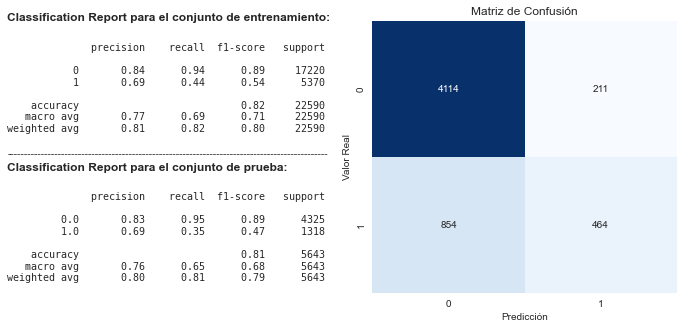

<Figure size 288x216 with 0 Axes>

In [38]:
logistic_model1 = LogisticRegression(random_state=42)
logistic_model1.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model1.predict(X_train)
y_pred_test = logistic_model1.predict(X_test)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
show_metrics_extras(y_train_clasification, y_pred_train, title='Metricas extras En Entrenamiento')
show_metrics_extras(y_test_clasification, y_pred_test, title='Metricas extras En Test')
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## Regresión logística con penalización por clases

Metricas extras En Test
Especificidad: 0.7916763005780347
Precisión Balanceada: 0.7342296525651935
Coeficiente de Correlación de Matthews: 0.42569850145099075
Kappa:  0.41630318749866024
Metricas extras En Entrenamiento
Especificidad: 0.7538327526132405
Precisión Balanceada: 0.7541044582433055
Coeficiente de Correlación de Matthews: 0.44884946600999154
Kappa:  0.42811116455502474


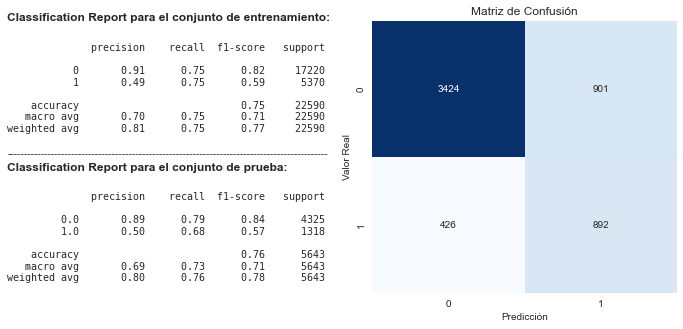

<Figure size 288x216 with 0 Axes>

In [39]:
logistic_model2 = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model2.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model2.predict(X_train)
y_pred_test = logistic_model2.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')
show_metrics_extras(y_test_clasification, y_pred_test, title='Metricas extras En Test')
show_metrics_extras(y_train_clasification, y_pred_train, title='Metricas extras En Entrenamiento')
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)

# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## Regresión logística con balanceo de clases SMOTE

In [40]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_clasification)

Metricas extras En Entrenamiento
Especificidad: 0.7455865272938443
Precisión Balanceada: 0.7498882357139613
Coeficiente de Correlación de Matthews: 0.4398693356846931
Kappa:  0.4178278525954199
Metricas extras En Test
Especificidad: 0.7842774566473989
Precisión Balanceada: 0.7214255265027587
Coeficiente de Correlación de Matthews: 0.40195080801417854
Kappa:  0.39280947502003605


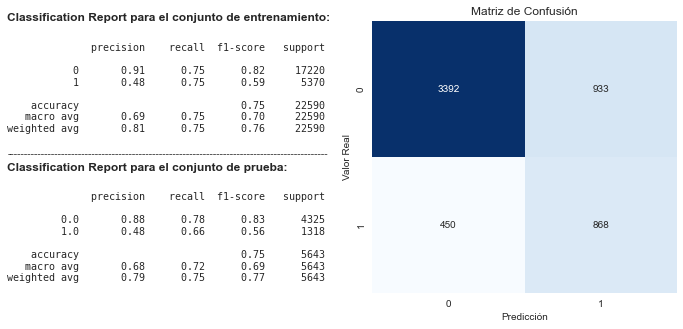

<Figure size 288x216 with 0 Axes>

In [41]:
logistic_model3 = LogisticRegression(random_state=42)
logistic_model3.fit(X_train_resampled, y_train_resampled)

# Hacer predicciones
y_pred_train = logistic_model3.predict(X_train)
y_pred_test = logistic_model3.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')

ax1.axis('off')
show_metrics_extras(y_train_clasification, y_pred_train, title='Metricas extras En Entrenamiento')
show_metrics_extras(y_test_clasification, y_pred_test, title='Metricas extras En Test')
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

Umbral óptimo para el modelo 1: 0.22811276856669724
Umbral óptimo para el modelo 2: 0.4949610251107166
Umbral óptimo para el modelo 3: 0.4709929998276028


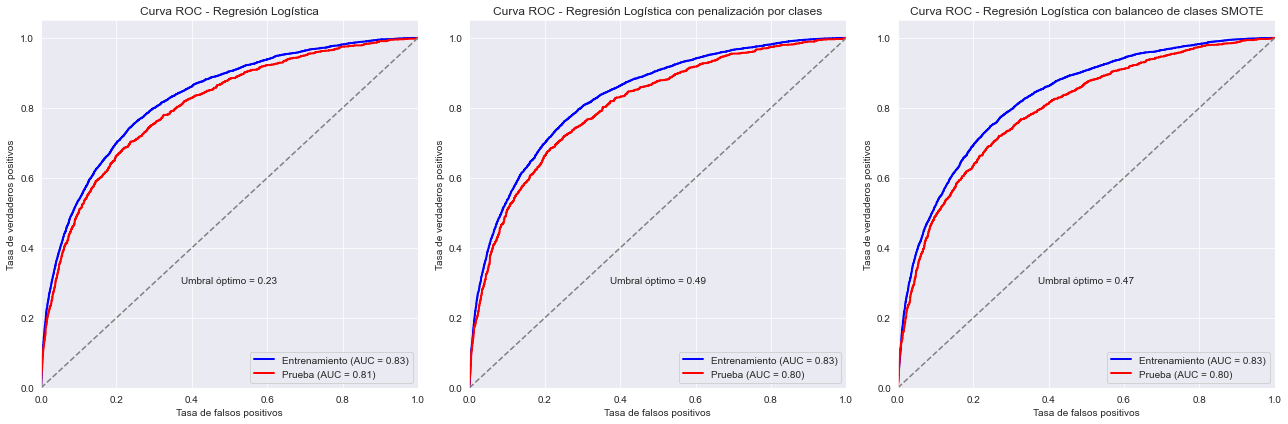

In [42]:
# Obtener las probabilidades de predicción de la clase positiva para entrenamiento y prueba para cada modelo
y_pred_proba_train1 = logistic_model1.predict_proba(X_train)[:, 1]
y_pred_proba_test1 = logistic_model1.predict_proba(X_test)[:, 1]

y_pred_proba_train2 = logistic_model2.predict_proba(X_train)[:, 1]
y_pred_proba_test2 = logistic_model2.predict_proba(X_test)[:, 1]

y_pred_proba_train3 = logistic_model3.predict_proba(X_train)[:, 1]
y_pred_proba_test3 = logistic_model3.predict_proba(X_test)[:, 1]

# Calcula la curva ROC y el área bajo la curva para el modelo 1
fpr_train1, tpr_train1, _ = roc_curve(y_train_clasification, y_pred_proba_train1)
fpr_test1, tpr_test1, umbrales_test1 = roc_curve(y_test_clasification, y_pred_proba_test1)
auc_train1 = roc_auc_score(y_train_clasification, y_pred_proba_train1)
auc_test1 = roc_auc_score(y_test_clasification, y_pred_proba_test1)

# Encuentra el umbral óptimo para el modelo 1
indice_umbral_optimo1 = np.argmax(tpr_test1 - fpr_test1)
umbral_optimo_modelo1 = umbrales_test1[indice_umbral_optimo1]

print("Umbral óptimo para el modelo 1:", umbral_optimo_modelo1)

# Calcula la curva ROC y el área bajo la curva para el modelo 2
fpr_train2, tpr_train2, _ = roc_curve(y_train_clasification, y_pred_proba_train2)
fpr_test2, tpr_test2, umbrales_test2 = roc_curve(y_test_clasification, y_pred_proba_test2)
auc_train2 = roc_auc_score(y_train_clasification, y_pred_proba_train2)
auc_test2 = roc_auc_score(y_test_clasification, y_pred_proba_test2)

# Encuentra el umbral óptimo para el modelo 2
indice_umbral_optimo2 = np.argmax(tpr_test2 - fpr_test2)
umbral_optimo_modelo2 = umbrales_test2[indice_umbral_optimo2]

print("Umbral óptimo para el modelo 2:", umbral_optimo_modelo2)

# Calcula la curva ROC y el área bajo la curva para el modelo 3
fpr_train3, tpr_train3, _ = roc_curve(y_train_clasification, y_pred_proba_train3)
fpr_test3, tpr_test3, umbrales_test3 = roc_curve(y_test_clasification, y_pred_proba_test3)
auc_train3 = roc_auc_score(y_train_clasification, y_pred_proba_train3)
auc_test3 = roc_auc_score(y_test_clasification, y_pred_proba_test3)

# Encuentra el umbral óptimo para el modelo 3
indice_umbral_optimo3 = np.argmax(tpr_test3 - fpr_test3)
umbral_optimo_modelo3 = umbrales_test3[indice_umbral_optimo3]

print("Umbral óptimo para el modelo 3:", umbral_optimo_modelo3)


# Trazar las curvas ROC para entrenamiento y prueba para cada modelo en una sola fila
plt.figure(figsize=(18, 6))

# Modelo 1
plt.subplot(1, 3, 1)
plt.plot(fpr_train1, tpr_train1, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train1)
plt.plot(fpr_test1, tpr_test1, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test1)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.text(0.5, 0.3, f'Umbral óptimo = {umbral_optimo_modelo1:.2f}', fontsize=10, ha='center')

# Modelo 2
plt.subplot(1, 3, 2)
plt.plot(fpr_train2, tpr_train2, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train2)
plt.plot(fpr_test2, tpr_test2, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística con penalización por clases')
plt.legend(loc='lower right')
plt.text(0.5, 0.3, f'Umbral óptimo = {umbral_optimo_modelo2:.2f}', fontsize=10, ha='center')

# Modelo 3
plt.subplot(1, 3, 3)
plt.plot(fpr_train3, tpr_train3, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train3)
plt.plot(fpr_test3, tpr_test3, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test3)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC - Regresión Logística con balanceo de clases SMOTE')
plt.legend(loc='lower right')
plt.text(0.5, 0.3, f'Umbral óptimo = {umbral_optimo_modelo3:.2f}', fontsize=10, ha='center')

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


Metricas extras En Entrenamiento
Especificidad: 0.7455865272938443
Precisión Balanceada: 0.7498882357139613
Coeficiente de Correlación de Matthews: 0.4398693356846931
Kappa:  0.4178278525954199
Metricas extras En Test
Especificidad: 0.7842774566473989
Precisión Balanceada: 0.7214255265027587
Coeficiente de Correlación de Matthews: 0.40195080801417854
Kappa:  0.39280947502003605


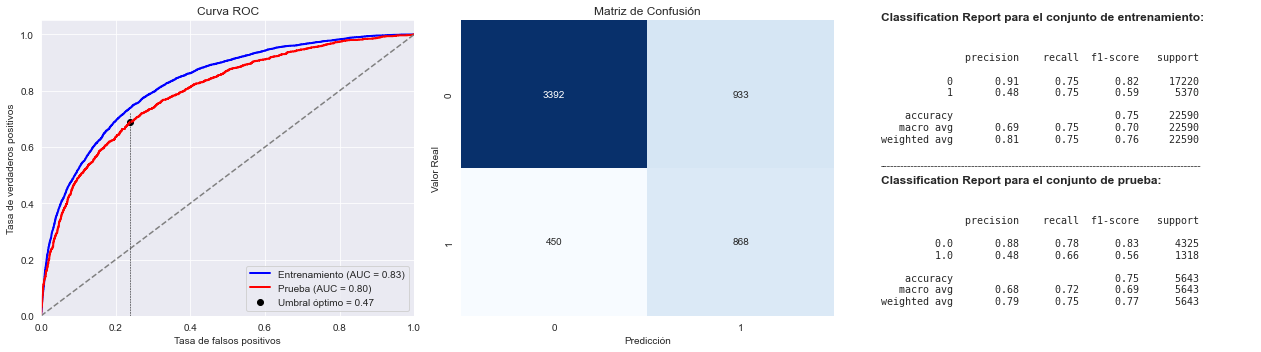

In [43]:
logistic_model_SMOTE_HYPER = LogisticRegression(random_state=42, class_weight='balanced')
logistic_model_SMOTE_HYPER.fit(X_train_resampled, y_train_resampled)

# Calcular las probabilidades de predicción para la clase positiva
y_pred_proba_train = logistic_model_SMOTE_HYPER.predict_proba(X_train)[:, 1]
y_pred_proba_test = logistic_model_SMOTE_HYPER.predict_proba(X_test)[:, 1]

# Calcular las curvas ROC y AUC
fpr_train, tpr_train, _ = roc_curve(y_train_clasification, y_pred_proba_train)
fpr_test, tpr_test, umbrales_test = roc_curve(y_test_clasification, y_pred_proba_test)
auc_train = roc_auc_score(y_train_clasification, y_pred_proba_train)
auc_test = roc_auc_score(y_test_clasification, y_pred_proba_test)

# Encontrar el umbral óptimo
umbral_optimo = umbrales_test[np.argmax(tpr_test - fpr_test)]

# Crear una nueva figura y subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Trazar la curva ROC en el primer subplot
ax1.plot(fpr_train, tpr_train, color='blue', lw=2, label='Entrenamiento (AUC = %0.2f)' % auc_train)
ax1.plot(fpr_test, tpr_test, color='red', lw=2, label='Prueba (AUC = %0.2f)' % auc_test)
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.scatter(fpr_test[np.argmax(tpr_test - fpr_test)], tpr_test[np.argmax(tpr_test - fpr_test)], marker='o', color='black', label=f'Umbral óptimo = {umbral_optimo:.2f}')
ax1.axvline(x=fpr_test[np.argmax(tpr_test - fpr_test)], color='black', linestyle='--', ymax=tpr_test[np.argmax(tpr_test - fpr_test)], linewidth=0.5)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de falsos positivos')
ax1.set_ylabel('Tasa de verdaderos positivos')
ax1.set_title('Curva ROC')
ax1.legend(loc='lower right')

# Mostrar la matriz de confusión como un mapa de calor en el segundo subplot
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')

# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax3.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax3.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax3.axis('off')

# Añadir una pequeña separación vertical
ax3.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax3.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax3.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')
ax3.axis('off')

# Mostrar las métricas extras
show_metrics_extras(y_train_clasification, y_pred_train, title='Metricas extras En Entrenamiento')
show_metrics_extras(y_test_clasification, y_pred_test, title='Metricas extras En Test')

plt.tight_layout()
plt.show()


## Regresion logistica con Hiper Parametros 

In [44]:
import pandas as pd


def print_dataframe(filtered_cv_results):
    ### print de los resultados de cross validation
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.7, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [45]:
from sklearn.preprocessing import StandardScaler

# Definir los parámetros del modelo a tunear
tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10, 100], "solver": ['newton-cg'], "max_iter": [200, 1000]}
]

# Definir las métricas de evaluación
scores = ["precision", "recall"]

# Escalar los datos de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir la estrategia de refit (utilizar 'recall' como métrica principal para refit)
refit_strategy = "recall"

# Configurar y ajustar GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(),
    param_grid=tuned_parameters,
    scoring={'precision': 'precision', 'recall': 'recall'},
    refit=refit_strategy,
    cv=5
)

# Ajustar el modelo
grid_search.fit(X_train_scaled, y_train_clasification)

# Mejor combinación de hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Mejor modelo
best_model = grid_search.best_estimator_

# Predicciones y métricas con el mejor modelo
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Evaluar el modelo
print("Reporte de clasificación en datos de entrenamiento:")
print(classification_report(y_train_clasification, y_pred_train))

print("Reporte de clasificación en datos de prueba:")
print(classification_report(y_test_clasification, y_pred_test))


Mejores hiperparámetros: {'C': 10, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
Reporte de clasificación en datos de entrenamiento:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     17220
           1       0.49      0.75      0.59      5370

    accuracy                           0.75     22590
   macro avg       0.70      0.75      0.71     22590
weighted avg       0.81      0.75      0.77     22590

Reporte de clasificación en datos de prueba:
              precision    recall  f1-score   support

         0.0       0.89      0.79      0.84      4325
         1.0       0.50      0.68      0.57      1318

    accuracy                           0.76      5643
   macro avg       0.69      0.73      0.71      5643
weighted avg       0.80      0.76      0.78      5643



###  En este caso, elegimos recall, ya que mide la proporción de verdaderos positivos entre todas las instancias que realmente son positivas. Al centrarnos en el recall, estamos evaluando la capacidad del modelo para capturar correctamente los casos en que realmente llueve.  Una alta tasa de recall indica que el modelo es efectivo para identificar los casos de lluvia, lo que es crucial si el costo de los falsos negativos es alto y quieres minimizarlos. 

##### Falsos Negativos (FN)

Un falso negativo en este contexto ocurre cuando el modelo predice que no va a llover mañana, pero en realidad sí llueve.

##### Falsos Positivos (FP)

Un falso positivo en este contexto ocurre cuando el modelo predice que va a llover mañana, pero en realidad no llueve.

En el contexto de nuestro problema, la clasificación incorrecta puede resultar en inconvenientes menores, como salir sin paraguas o llevar un paraguas innecesariamente. Sin embargo, en contextos donde intervienen factores más serios, como la salud de una persona, los impactos de los falsos negativos y falsos positivos pueden ser mucho más graves.

Por ejemplo, en el caso de una enfermedad, un falso negativo podría significar que una enfermedad grave no se detecta a tiempo, poniendo en peligro la vida del paciente. Un falso positivo podría llevar a tratamientos innecesarios, ansiedad y costos adicionales. Por lo tanto, en tales contextos, nuestro objetivo sería minimizar estos errores tanto como sea posible. Idealmente, buscariamos reducir a cero los valores de falsos negativos, ya que no detectar una condición crítica puede tener consecuencias severas. En caso de no poder eliminar completamente estos errores, trataríamos de reducirlos al mínimo número posible para garantizar la seguridad y el bienestar de las personas.

##### umbrales
Tras analizar los umbrales óptimos obtenidos para los tres modelos, observamos diferencias significativas que reflejan las características particulares de cada enfoque de modelado.

Para el Modelo 1, que se construyó sobre datos desbalanceados, el umbral óptimo identificado es de 0.23. Este valor tan bajo sugiere una tendencia a clasificar más instancias como positivas, lo cual es comprensible dado el desbalance en los datos. Aquí, un umbral cercano a 0.5 podría no ser el más adecuado, dada la distribución de clases.

En contraste, el Modelo 2 incorporó una estrategia de ponderación de clases para abordar el desbalance. Con un umbral óptimo de 0.49, este modelo muestra una mayor sensibilidad hacia los verdaderos positivos, lo que sugiere una mejor capacidad para detectar casos positivos en un conjunto de datos más equilibrado. Aunque el umbral se acerca a 0.5, indicando una tendencia a la neutralidad, su ligero descenso sugiere una adaptación a la corrección de clases desbalanceadas.

Por último, el Modelo 3 se construyó sobre datos balanceados mediante la técnica SMOTE. Su umbral óptimo, alrededor de 0.47, refleja una ponderación similar entre precisión y sensibilidad. Aunque no es significativamente diferente de 0.5, esta ligera variación indica una consideración hacia la corrección del desbalance y la preservación de la sensibilidad del modelo.

##### Fitting
El rendimiento de nuestro modelo, con un recall del 75% en ambas clases y un área bajo la curva (AUC) de 0.80, sugiere un ajuste notablemente sólido a los datos. Un recall del 75% indica que nuestro modelo puede identificar correctamente el 75% de todas las instancias positivas, lo que refleja su capacidad para capturar de manera efectiva los casos relevantes.

El AUC, por otro lado, es una medida de la capacidad del modelo para distinguir entre clases. Con un valor de 0.80, nuestro modelo muestra una buena capacidad para discriminar entre las clases positiva y negativa, lo que indica que es capaz de clasificar adecuadamente las instancias en función de su clase verdadera.

La combinación de un recall equilibrado en ambas clases y un AUC sólido sugiere que nuestro modelo está logrando un buen equilibrio entre la sensibilidad y la especificidad, lo que significa que no solo puede identificar positivos con precisión, sino que también puede distinguir con éxito entre los positivos y los negativos.



## Explicabilidad del modelo con SHAP

### INTERPRETABILIDAD LOCAL CLASIFICACIÓN

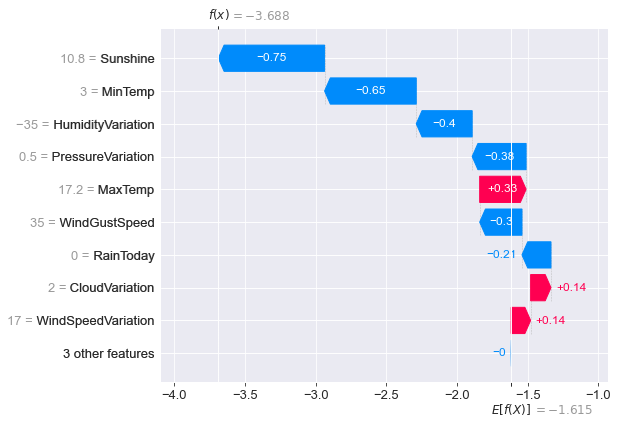

In [46]:
explainer = shap.LinearExplainer(logistic_model1, X_train)
shap_values = explainer(X_test)
index=0
logistic_model1.predict_proba(X_test)[index]
logistic_model1.predict(X_test)[index]
shap_values[index]
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=X_train.columns)
shap.plots.waterfall(explanation)

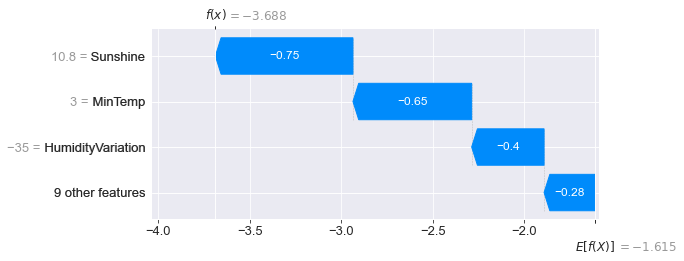

In [47]:
shap.plots.waterfall(explanation, max_display=4)


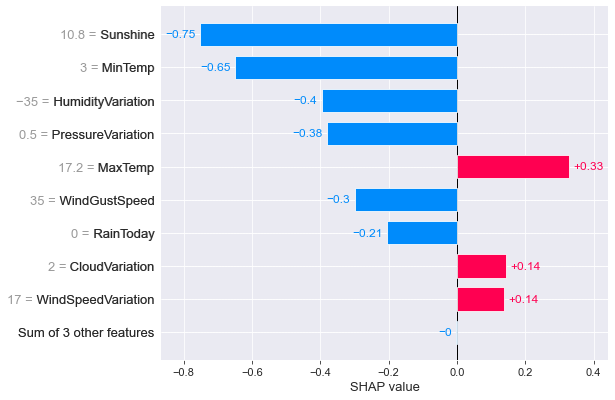

In [48]:
shap.plots.bar(explanation)

### INTEPRETABILIDAD GLOBAL CLASIFICACIÓN

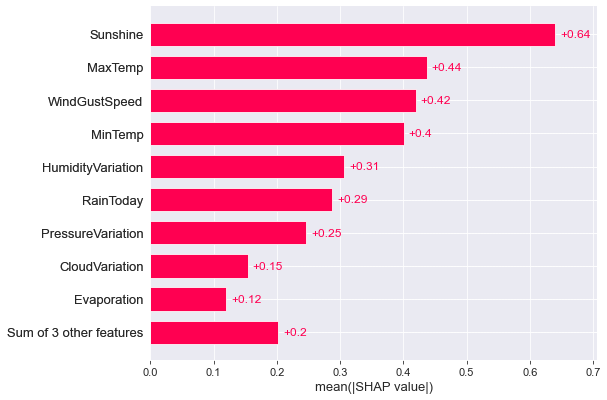

In [49]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=X_test.columns, data=X_test)
shap.plots.bar(explanation)

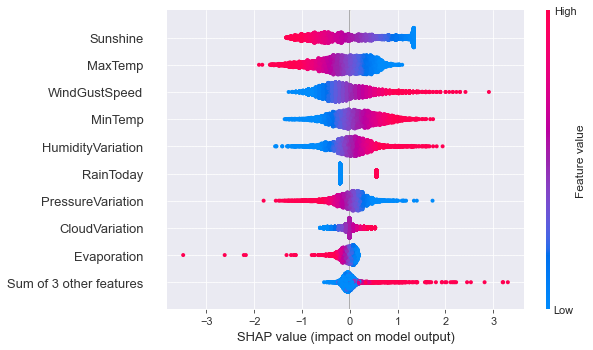

In [50]:
shap.plots.beeswarm(explanation)

### INTEPRETABILIDAD LOCAL REGRESIÓN

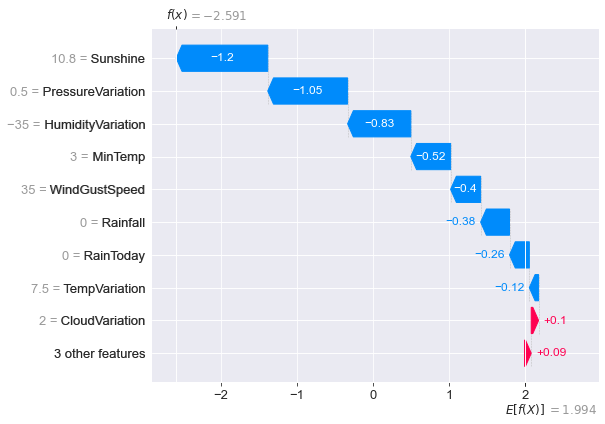

In [51]:
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer(X_test)
index=0
model.predict(X_test)[index]
shap_values[index]
explanation = shap.Explanation(values=shap_values[index], base_values=explainer.expected_value, feature_names=X_train.columns)
shap.plots.waterfall(explanation)

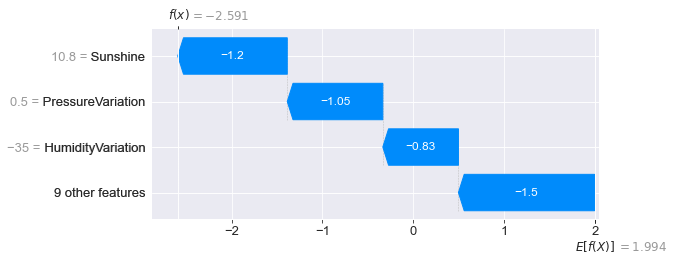

In [52]:
shap.plots.waterfall(explanation, max_display=4)

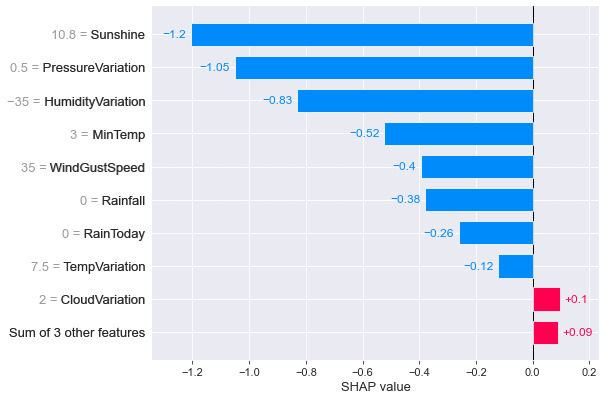

In [53]:
shap.plots.bar(explanation)

### INTEPRETABILIDAD GLOBAL REGRESIÓN

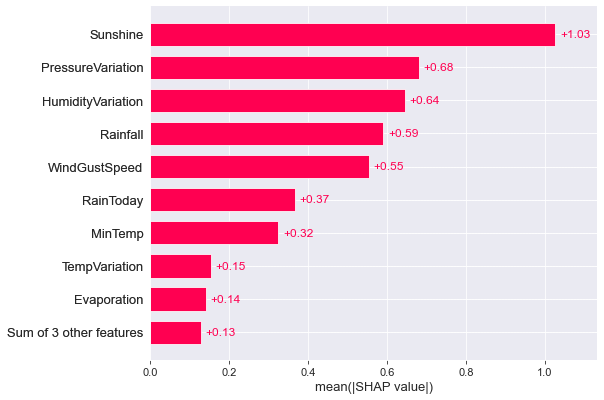

In [54]:
explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, feature_names=X_test.columns, data=X_test)
shap.plots.bar(explanation)

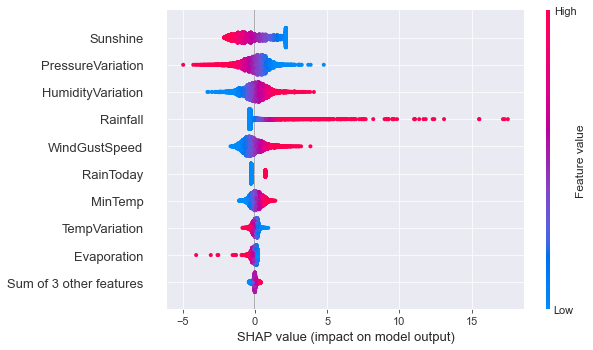

In [55]:
shap.plots.beeswarm(explanation)

El gráfico de valores SHAP revela la importancia y el impacto de cada característica en las predicciones del modelo. 

Características con valores SHAP más altos, como rainfall, tienen una influencia más fuerte en las predicciones, mientras que aquellos cerca de cero tienen un efecto mínimo, como las que aparecen como la suma de otras 3 features.

Cada punto representa un valor SHAP de una característica para una observación específica. 

La dispersión de los puntos a lo largo del eje X indica la magnitud y la dirección del impacto de la característica en la predicción. 

Características más importantes están ubicadas más arriba en el gráfico

Las variables más importantes en el modelo de clasificación son Sunshine, MaxTemp y WindGustSpeed

las variables menos importantes en el modelo de clasificación son Evaporation y CloudVariation

Las variables más importantes en el modelo de regresión son Sunshine, PressureVariation y HumidityVariation

las variables menos importantes en el modelo de regresión son Evaporation y TempVariation

Podemos observar que no coinciden en ambos modelos

## Modelo Base para Clasificación

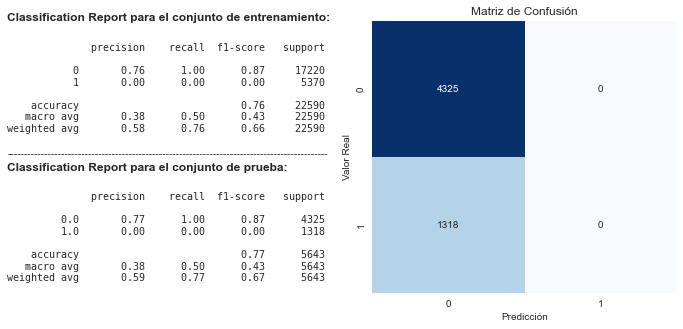

<Figure size 288x216 with 0 Axes>

In [56]:
# Crear el clasificador ingenuo que predice la clase mayoritaria
naive_classifier = DummyClassifier(strategy="most_frequent")

# Entrenar el modelo con los datos de entrenamiento
naive_classifier.fit(X_train, y_train_clasification)

# Hacer predicciones sobre los datos de entrenamiento y prueba
y_pred_train = naive_classifier.predict(X_train)
y_pred_test = naive_classifier.predict(X_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Mostrar el cuadro de texto (classification report) para el conjunto de entrenamiento
ax1.text(0, 1, "Classification Report para el conjunto de entrenamiento:", fontsize=12, weight='bold')
ax1.text(0, 0.55, classification_report(y_train_clasification, y_pred_train), fontsize=10, family='monospace')
ax1.axis('off')

# Añadir una pequeña separación vertical
ax1.text(0, 0.5, "-" * 95, fontsize=10)

# Mostrar el cuadro de texto (classification report) para el conjunto de prueba
ax1.text(0, 0.45, "Classification Report para el conjunto de prueba:", fontsize=12, weight='bold')
ax1.text(0, 0, classification_report(y_test_clasification, y_pred_test), fontsize=10, family='monospace')
ax1.axis('off')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test_clasification, y_pred_test)
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, ax=ax2)
ax2.set_xlabel('Predicción')
ax2.set_ylabel('Valor Real')
ax2.set_title('Matriz de Confusión')
plt.tight_layout()
plt.show()

## curva ROC de modelo base

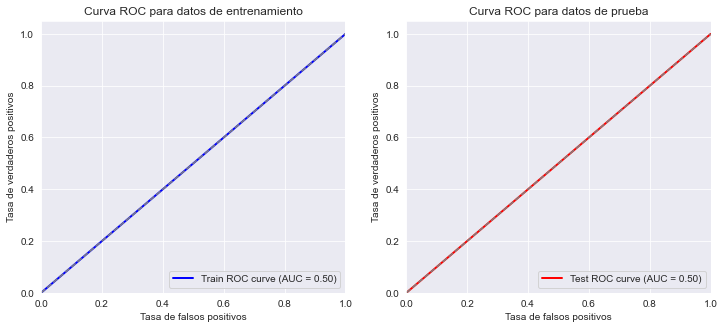

In [57]:
# Obtener las probabilidades de predicción de la clase positiva (la clase mayoritaria)
y_pred_proba_train = np.full_like(y_train_clasification, fill_value=1)  # Clase mayoritaria
y_pred_proba_test = np.full_like(y_test_clasification, fill_value=1)  # Clase mayoritaria

# Calcular la curva ROC para los datos de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train_clasification, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test_clasification, y_pred_proba_test)

# Calcular el área bajo la curva ROC (AUC) para los datos de entrenamiento y prueba
auc_train = roc_auc_score(y_train_clasification, y_pred_proba_train)
auc_test = roc_auc_score(y_test_clasification, y_pred_proba_test)

# Crear la figura con dos subplots uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Trazar la curva ROC para los datos de entrenamiento
ax1.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (AUC = %0.2f)' % auc_train)
ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Tasa de falsos positivos')
ax1.set_ylabel('Tasa de verdaderos positivos')
ax1.set_title('Curva ROC para datos de entrenamiento')
ax1.legend(loc='lower right')

# Trazar la curva ROC para los datos de prueba
ax2.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (AUC = %0.2f)' % auc_test)
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Tasa de falsos positivos')
ax2.set_ylabel('Tasa de verdaderos positivos')
ax2.set_title('Curva ROC para datos de prueba')
ax2.legend(loc='lower right')

# Mostrar la figura
plt.show()


Podemos observar que el modelo base no tiene capacidad discriminativa mejor que una predicción aleatoria, no puede distinguir entre las clases positivas y negativas de manera significativa, lo que limita su utilidad para clasificar correctamente los datos. 

## Modelo Base para Regresión

In [58]:
# Crear un DummyRegressor que predice la media de la variable objetivo
dummy_regressor = DummyRegressor(strategy='mean')

# Entrenar el modelo de regresión base con los datos de entrenamiento
dummy_regressor.fit(X_train, y_train)

# Hacer predicciones con el modelo de regresión base en los datos de entrenamiento y prueba
y_pred_train_base = dummy_regressor.predict(X_train)
y_pred_test_base = dummy_regressor.predict(X_test)

# Calcular el error cuadrático medio (MSE) del modelo de regresión base para el conjunto de entrenamiento y prueba
mse_train_base = mean_squared_error(y_train, y_pred_train_base)
mse_test_base = mean_squared_error(y_test, y_pred_test_base)

# Calcular el Error Absoluto Medio (MAE) para el conjunto de entrenamiento y prueba
mae_train_base = mean_absolute_error(y_train, y_pred_train_base)
mae_test_base = mean_absolute_error(y_test, y_pred_test_base)

# Calcular el Error Porcentual Absoluto Medio (MAPE) para el conjunto de prueba
mape_test_base = np.mean(np.abs((y_test - y_pred_test_base) / y_test)) * 100

# Calcular el coeficiente de determinación (R-cuadrado) para el conjunto de prueba
r2_test_base = r2_score(y_test, y_pred_test_base)

# Imprimir las métricas
print("Métricas para el modelo de regresión base:")
print("Error cuadrático medio (MSE) (Train):", mse_train_base)
print("Error cuadrático medio (MSE) (Test):", mse_test_base)
print("Mean Absolute Error (MAE) (Train):", mae_train_base)
print("Mean Absolute Error (MAE) (Test):", mae_test_base)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_base)
print("R-squared (Test):", r2_test_base)


Métricas para el modelo de regresión base:
Error cuadrático medio (MSE) (Train): 40.16035584690895
Error cuadrático medio (MSE) (Test): 44.66972245810008
Mean Absolute Error (MAE) (Train): 3.0123050980378325
Mean Absolute Error (MAE) (Test): 3.15374211347651
Mean Absolute Percentage Error (MAPE) (Test): inf
R-squared (Test): -0.00038056569167110865


Podemos observar que la estrategia de implementar un modelo base de regresión tiene métricas inferiores a la regresión lineal simple y esto nos sirve como indicio para determinar que este modelo no se ajusta bien a nuestro problema, debido a esto decidimos que para los problemas de regresión vamos a optar por el método de la regresión lineal múltiple. Esta elección es parcial ya que aún no implementamos la solución con redes neuronales

# Red neuronal para Regresion

In [59]:
model = Sequential()
model.add(Dense(32, input_shape=(12,), activation='relu'))
model.add(Dense(1, activation='linear')) 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

show_metrics_regresion(y_train, y_pred_train,"Métricas del conjunto de entrenamiento:", False)
show_metrics_regresion(y_test, y_pred_test,"Métricas del conjunto de Prueba:", False)

177/177 [==============================] - 0s 539us/step
Métricas del conjunto de entrenamiento:
Mean Squared Error : 29.123207073946954
R-squared: 0.2748269665496875
Mean Absolute Error (MAE): 2.5170174255364235
Métricas del conjunto de Prueba:
Mean Squared Error : 32.16472703320371
R-squared: 0.27966940347622915
Mean Absolute Error (MAE): 2.659184616636178


# Optuna

In [61]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def objective(trial):
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 20)
    hidden_layer_size = trial.suggest_int('hidden_layer_size', 16, 400)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'sgd'])
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    
    model = Sequential()
    model.add(Dense(hidden_layer_size, input_shape=(12,), activation=activation))
    model.add(Dropout(dropout_rate))
    for _ in range(num_hidden_layers):
        model.add(Dense(hidden_layer_size, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
        
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping], verbose=0)
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    
    return mse_train

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_model = Sequential()
best_model.add(Dense(best_params['hidden_layer_size'], input_shape=(12,), activation=best_params['activation']))
best_model.add(Dropout(best_params['dropout_rate']))
for _ in range(best_params['num_hidden_layers']):
    best_model.add(Dense(best_params['hidden_layer_size'], activation=best_params['activation']))
    best_model.add(Dropout(best_params['dropout_rate']))
best_model.add(Dense(1, activation='linear'))

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'rmsprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

best_model.compile(optimizer=optimizer, loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
best_model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32, callbacks=[early_stopping], verbose=1)
y_pred_test = best_model.predict(X_test)
print("Mejores Hiperparámetros:", best_params)
show_metrics_regresion(y_test, y_pred_test, "Conjunto de Prueba:", nr_neuronal=False)


[I 2024-06-20 16:11:24,333] A new study created in memory with name: no-name-58c1590a-0f97-494e-bd60-4a978331408d


706/706 [==============================] - 1s 2ms/step


[I 2024-06-20 16:12:59,471] Trial 0 finished with value: 35.59669481096997 and parameters: {'num_hidden_layers': 12, 'hidden_layer_size': 301, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.2887378713045323, 'learning_rate': 2.8077751091372426e-05}. Best is trial 0 with value: 35.59669481096997.


706/706 [==============================] - 1s 1ms/step


[I 2024-06-20 16:13:20,026] Trial 1 finished with value: 40.02285424820906 and parameters: {'num_hidden_layers': 17, 'hidden_layer_size': 133, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.3555178983452151, 'learning_rate': 2.168825905931261e-05}. Best is trial 0 with value: 35.59669481096997.


706/706 [==============================] - 1s 970us/step


[I 2024-06-20 16:13:36,891] Trial 2 finished with value: 38.4589312430542 and parameters: {'num_hidden_layers': 14, 'hidden_layer_size': 113, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.40627295360546983, 'learning_rate': 0.0022895034045149064}. Best is trial 0 with value: 35.59669481096997.


706/706 [==============================] - 1s 847us/step


[I 2024-06-20 16:13:51,212] Trial 3 finished with value: 34.33609264266499 and parameters: {'num_hidden_layers': 10, 'hidden_layer_size': 116, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.21765230915002093, 'learning_rate': 0.00328126359180871}. Best is trial 3 with value: 34.33609264266499.


706/706 [==============================] - 1s 1ms/step


[I 2024-06-20 16:14:20,469] Trial 4 finished with value: 32.95617188951323 and parameters: {'num_hidden_layers': 6, 'hidden_layer_size': 245, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_rate': 0.29958151480487866, 'learning_rate': 3.890988667446964e-05}. Best is trial 4 with value: 32.95617188951323.


706/706 [==============================] - 1s 978us/step


[I 2024-06-20 16:14:33,238] Trial 5 finished with value: 40.17194378769502 and parameters: {'num_hidden_layers': 10, 'hidden_layer_size': 105, 'activation': 'sigmoid', 'optimizer': 'sgd', 'dropout_rate': 0.031337526059293686, 'learning_rate': 0.0001474653887647674}. Best is trial 4 with value: 32.95617188951323.


706/706 [==============================] - 1s 689us/step


[I 2024-06-20 16:14:43,137] Trial 6 finished with value: 37.477078312214026 and parameters: {'num_hidden_layers': 10, 'hidden_layer_size': 26, 'activation': 'relu', 'optimizer': 'adam', 'dropout_rate': 0.2984093538215458, 'learning_rate': 0.0005348179885499434}. Best is trial 4 with value: 32.95617188951323.


706/706 [==============================] - 1s 783us/step


[I 2024-06-20 16:15:01,306] Trial 7 finished with value: 31.629128123690396 and parameters: {'num_hidden_layers': 2, 'hidden_layer_size': 307, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_rate': 0.37195805414788946, 'learning_rate': 2.95233113166029e-05}. Best is trial 7 with value: 31.629128123690396.


706/706 [==============================] - 1s 763us/step


[I 2024-06-20 16:15:11,216] Trial 8 finished with value: 38.26058651454248 and parameters: {'num_hidden_layers': 12, 'hidden_layer_size': 27, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.3274154213194458, 'learning_rate': 9.345405469987683e-05}. Best is trial 7 with value: 31.629128123690396.


706/706 [==============================] - 1s 2ms/step


[I 2024-06-20 16:16:05,593] Trial 9 finished with value: 41.53056457359318 and parameters: {'num_hidden_layers': 8, 'hidden_layer_size': 387, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.4275014707984456, 'learning_rate': 4.730391300008181e-05}. Best is trial 7 with value: 31.629128123690396.


706/706 [==============================] - 1s 940us/step


[I 2024-06-20 16:16:23,419] Trial 10 finished with value: 35.726891699005826 and parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 391, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.489978630094943, 'learning_rate': 1.0916743986416533e-05}. Best is trial 7 with value: 31.629128123690396.


706/706 [==============================] - 1s 2ms/step


[I 2024-06-20 16:16:41,857] Trial 11 finished with value: 33.08764372447294 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size': 263, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_rate': 0.20875680269130742, 'learning_rate': 1.070884294875296e-05}. Best is trial 7 with value: 31.629128123690396.


706/706 [==============================] - 1s 1ms/step


[I 2024-06-20 16:20:32,202] Trial 12 finished with value: 30.440831567817597 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size': 270, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_rate': 0.22932044410812472, 'learning_rate': 9.202923708852955e-05}. Best is trial 12 with value: 30.440831567817597.


706/706 [==============================] - 2s 2ms/step


[I 2024-06-20 16:21:14,764] Trial 13 finished with value: 31.729646901015812 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size': 322, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.16154104336565508, 'learning_rate': 0.00021536905851068965}. Best is trial 12 with value: 30.440831567817597.


706/706 [==============================] - 0s 580us/step


[I 2024-06-20 16:21:27,695] Trial 14 finished with value: 31.02515362554314 and parameters: {'num_hidden_layers': 2, 'hidden_layer_size': 186, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.15136617012476844, 'learning_rate': 7.817611489744787e-05}. Best is trial 12 with value: 30.440831567817597.


706/706 [==============================] - 0s 596us/step


[I 2024-06-20 16:21:39,246] Trial 15 finished with value: 29.505486357318468 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size': 175, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.14724519227315108, 'learning_rate': 0.0003571563178222437}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 681us/step


[I 2024-06-20 16:21:57,971] Trial 16 finished with value: 30.470624369517466 and parameters: {'num_hidden_layers': 6, 'hidden_layer_size': 186, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.06948191954906552, 'learning_rate': 0.00042460426143632574}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 845us/step


[I 2024-06-20 16:22:17,755] Trial 17 finished with value: 31.747294245249204 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size': 251, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.13029499479119996, 'learning_rate': 0.0008822923556765322}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 2ms/step


[I 2024-06-20 16:23:14,189] Trial 18 finished with value: 35.005015719595995 and parameters: {'num_hidden_layers': 19, 'hidden_layer_size': 216, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.228137365935519, 'learning_rate': 0.0002439611125635701}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 692us/step


[I 2024-06-20 16:23:28,068] Trial 19 finished with value: 33.02380265587529 and parameters: {'num_hidden_layers': 8, 'hidden_layer_size': 149, 'activation': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 0.10100790436006099, 'learning_rate': 0.0011808880272767023}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 599us/step


[I 2024-06-20 16:23:35,713] Trial 20 finished with value: 30.979288207477737 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size': 75, 'activation': 'sigmoid', 'optimizer': 'rmsprop', 'dropout_rate': 0.013827902452031832, 'learning_rate': 0.0075724462491992064}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 729us/step


[I 2024-06-20 16:23:53,600] Trial 21 finished with value: 30.36424455866844 and parameters: {'num_hidden_layers': 7, 'hidden_layer_size': 177, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.08267132736169636, 'learning_rate': 0.00037994398583218763}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 688us/step


[I 2024-06-20 16:24:10,936] Trial 22 finished with value: 30.624344794238237 and parameters: {'num_hidden_layers': 7, 'hidden_layer_size': 172, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.18395397562487673, 'learning_rate': 0.0003126164706792032}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 757us/step


[I 2024-06-20 16:24:29,180] Trial 23 finished with value: 29.96861167043835 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size': 214, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.1057969108247539, 'learning_rate': 0.000136231429107019}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 552us/step


[I 2024-06-20 16:24:37,801] Trial 24 finished with value: 30.166786923619757 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size': 163, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.094174796643815, 'learning_rate': 0.00017607869739496223}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 627us/step


[I 2024-06-20 16:24:46,128] Trial 25 finished with value: 30.879957505586976 and parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 221, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.1261221497239659, 'learning_rate': 0.00015870639009463137}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 579us/step


[I 2024-06-20 16:24:53,189] Trial 26 finished with value: 30.912282219789162 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size': 77, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.05079774950869387, 'learning_rate': 0.00016872999808643973}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 604us/step


[I 2024-06-20 16:25:02,361] Trial 27 finished with value: 29.513407506527223 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size': 155, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.1017806544620025, 'learning_rate': 0.0006403604329104788}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 814us/step


[I 2024-06-20 16:25:17,889] Trial 28 finished with value: 30.180527463519457 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size': 213, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.0492050665329566, 'learning_rate': 0.000625346079491983}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 2s 2ms/step


[I 2024-06-20 16:26:03,529] Trial 29 finished with value: 31.489111205085003 and parameters: {'num_hidden_layers': 8, 'hidden_layer_size': 331, 'activation': 'tanh', 'optimizer': 'sgd', 'dropout_rate': 2.3531752614644463e-05, 'learning_rate': 0.0008919632811161179}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 756us/step


[I 2024-06-20 16:26:18,431] Trial 30 finished with value: 31.39971610673825 and parameters: {'num_hidden_layers': 12, 'hidden_layer_size': 80, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.18320465475303088, 'learning_rate': 0.00031162124533388075}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 669us/step


[I 2024-06-20 16:26:29,534] Trial 31 finished with value: 29.719288485765983 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size': 156, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.10266495070574874, 'learning_rate': 0.0002479354399979325}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 653us/step


[I 2024-06-20 16:26:37,235] Trial 32 finished with value: 29.683569451550603 and parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 147, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.1150167484704005, 'learning_rate': 0.00047841873197364813}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 563us/step


[I 2024-06-20 16:26:44,789] Trial 33 finished with value: 29.69226793895178 and parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 143, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.14533475921447628, 'learning_rate': 0.0006056747704197813}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 610us/step


[I 2024-06-20 16:26:52,340] Trial 34 finished with value: 29.781887292017487 and parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 147, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.14418255435176355, 'learning_rate': 0.0006160253569238248}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 615us/step


[I 2024-06-20 16:27:00,193] Trial 35 finished with value: 30.118667916829654 and parameters: {'num_hidden_layers': 2, 'hidden_layer_size': 117, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.18229585613988264, 'learning_rate': 0.001204443428138408}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 608us/step


[I 2024-06-20 16:27:07,043] Trial 36 finished with value: 31.76868650011503 and parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 98, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.2560665226474288, 'learning_rate': 0.0019087780735649348}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 651us/step


[I 2024-06-20 16:27:15,141] Trial 37 finished with value: 33.95317229153409 and parameters: {'num_hidden_layers': 2, 'hidden_layer_size': 133, 'activation': 'sigmoid', 'optimizer': 'sgd', 'dropout_rate': 0.13150293729678328, 'learning_rate': 0.00048811228022066174}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 738us/step


[I 2024-06-20 16:27:29,699] Trial 38 finished with value: 31.819149428132885 and parameters: {'num_hidden_layers': 16, 'hidden_layer_size': 48, 'activation': 'tanh', 'optimizer': 'adam', 'dropout_rate': 0.06153938951454293, 'learning_rate': 0.0003940294643741982}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 935us/step


[I 2024-06-20 16:27:49,824] Trial 39 finished with value: 33.850161180828685 and parameters: {'num_hidden_layers': 14, 'hidden_layer_size': 133, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.11476189972178821, 'learning_rate': 0.0006957598567257798}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 747us/step


[I 2024-06-20 16:28:03,326] Trial 40 finished with value: 31.437032899186697 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size': 193, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.1594425551356158, 'learning_rate': 0.001457967879947747}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 700us/step


[I 2024-06-20 16:28:13,645] Trial 41 finished with value: 30.305586607162713 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size': 159, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.10014040574902086, 'learning_rate': 0.0002840743437346011}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 651us/step


[I 2024-06-20 16:28:21,657] Trial 42 finished with value: 29.658404122862375 and parameters: {'num_hidden_layers': 2, 'hidden_layer_size': 115, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.07614839907030661, 'learning_rate': 0.0004557700398064828}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 624us/step


[I 2024-06-20 16:28:28,746] Trial 43 finished with value: 29.571497404550087 and parameters: {'num_hidden_layers': 1, 'hidden_layer_size': 116, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.08057548986120372, 'learning_rate': 0.000488397947640452}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 0s 617us/step


[I 2024-06-20 16:28:36,689] Trial 44 finished with value: 29.647274407097804 and parameters: {'num_hidden_layers': 2, 'hidden_layer_size': 116, 'activation': 'tanh', 'optimizer': 'rmsprop', 'dropout_rate': 0.03370050118722548, 'learning_rate': 0.00041731665809552663}. Best is trial 15 with value: 29.505486357318468.


706/706 [==============================] - 1s 648us/step


[I 2024-06-20 16:28:44,341] Trial 45 finished with value: 29.14041750293331 and parameters: {'num_hidden_layers': 2, 'hidden_layer_size': 117, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_rate': 0.0340262233837224, 'learning_rate': 0.0007592374720017234}. Best is trial 45 with value: 29.14041750293331.


706/706 [==============================] - 1s 667us/step


[I 2024-06-20 16:28:52,420] Trial 46 finished with value: 30.677978399151815 and parameters: {'num_hidden_layers': 6, 'hidden_layer_size': 87, 'activation': 'relu', 'optimizer': 'sgd', 'dropout_rate': 0.03309035819824861, 'learning_rate': 0.0007932564746644907}. Best is trial 45 with value: 29.14041750293331.


706/706 [==============================] - 0s 558us/step


[I 2024-06-20 16:29:01,363] Trial 47 finished with value: 29.967140065436887 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size': 52, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_rate': 0.0403255462812888, 'learning_rate': 0.0009575440451752232}. Best is trial 45 with value: 29.14041750293331.


706/706 [==============================] - 1s 625us/step


[I 2024-06-20 16:29:11,242] Trial 48 finished with value: 30.327125798391858 and parameters: {'num_hidden_layers': 9, 'hidden_layer_size': 55, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_rate': 0.06539125097964854, 'learning_rate': 0.0003346875911592967}. Best is trial 45 with value: 29.14041750293331.


706/706 [==============================] - 0s 555us/step


[I 2024-06-20 16:29:18,048] Trial 49 finished with value: 29.967488108871812 and parameters: {'num_hidden_layers': 2, 'hidden_layer_size': 103, 'activation': 'relu', 'optimizer': 'rmsprop', 'dropout_rate': 0.022217104262009554, 'learning_rate': 0.0005868367541558014}. Best is trial 45 with value: 29.14041750293331.


Epoch 1/10
565/565 [==============================] - 1s 1ms/step - loss: 33.5913 - val_loss: 32.8173
Epoch 2/10
565/565 [==============================] - 1s 1ms/step - loss: 31.0708 - val_loss: 32.3005
Epoch 3/10
565/565 [==============================] - 1s 1ms/step - loss: 31.0367 - val_loss: 32.0214
Epoch 4/10
565/565 [==============================] - 1s 1ms/step - loss: 30.4764 - val_loss: 34.0015
Epoch 5/10
565/565 [==============================] - 1s 1ms/step - loss: 30.5986 - val_loss: 31.7988
Epoch 6/10
565/565 [==============================] - 1s 1ms/step - loss: 30.3752 - val_loss: 30.9533
Epoch 7/10
565/565 [==============================] - 1s 1ms/step - loss: 30.1614 - val_loss: 31.3778
Epoch 8/10
565/565 [==============================] - 1s 1ms/step - loss: 30.3114 - val_loss: 32.8140
Epoch 9/10
565/565 [==============================] - 1s 1ms/step - loss: 29.7422 - val_loss: 32.0262
Epoch 10/10
177/177 [==============================] - 0s 581us/step
Mejores Hiper

### Función de pérdida para el modelo de regresión

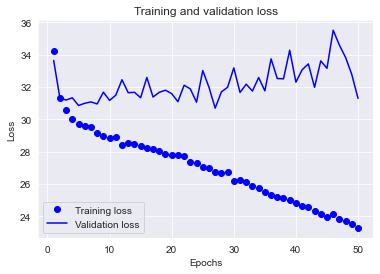

In [62]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Definir el modelo con los mejores hiperparámetros
model = Sequential()
model.add(Dense(61, input_shape=(12,), activation='relu'))  # Capa oculta con 61 neuronas
model.add(Dense(61, activation='relu'))  # Segunda capa oculta con 61 neuronas
model.add(Dense(1, activation='linear'))  # Capa de salida
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Obtener la pérdida durante el entrenamiento
loss = history.history['loss']
val_loss = history.history['val_loss']

# Graficar la pérdida durante el entrenamiento
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Red neuronal para Clasificacion


In [69]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss

best_params = {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005958432842192192, 'learning_rate_init': 0.0001422171191037891}
# Entrenar el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_model = MLPClassifier(**best_params, max_iter=200)
best_model.fit(X_train, y_train_clasification)

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train_clasification, y_train_pred)
train_loss = log_loss(y_train_clasification, best_model.predict_proba(X_train))
print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("Pérdida en el conjunto de entrenamiento:", train_loss)

# Evaluar el modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test_clasification, y_test_pred)
test_loss = log_loss(y_test_clasification, best_model.predict_proba(X_test))
print("Precisión en el conjunto de prueba:", test_accuracy)
print("Pérdida en el conjunto de prueba:", test_loss)



from sklearn.metrics import accuracy_score, log_loss, recall_score

# Evaluar el modelo en el conjunto de entrenamiento
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train_clasification, y_train_pred)
train_loss = log_loss(y_train_clasification, best_model.predict_proba(X_train))
train_recall = recall_score(y_train_clasification, y_train_pred, average='weighted')
print("Precisión en el conjunto de entrenamiento:", train_accuracy)
print("Pérdida en el conjunto de entrenamiento:", train_loss)
print("Recall en el conjunto de entrenamiento:", train_recall)

# Evaluar el modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test_clasification, y_test_pred)
test_loss = log_loss(y_test_clasification, best_model.predict_proba(X_test))
test_recall = recall_score(y_test_clasification, y_test_pred, average='weighted')
print("Precisión en el conjunto de prueba:", test_accuracy)
print("Pérdida en el conjunto de prueba:", test_loss)
print("Recall en el conjunto de prueba:", test_recall)

Precisión en el conjunto de entrenamiento: 0.831916777335104
Pérdida en el conjunto de entrenamiento: 0.38151114999956043
Precisión en el conjunto de prueba: 0.8208399787347156
Pérdida en el conjunto de prueba: 0.41678057531243856
Precisión en el conjunto de entrenamiento: 0.831916777335104
Pérdida en el conjunto de entrenamiento: 0.38151114999956043
Recall en el conjunto de entrenamiento: 0.831916777335104
Precisión en el conjunto de prueba: 0.8208399787347156
Pérdida en el conjunto de prueba: 0.41678057531243856
Recall en el conjunto de prueba: 0.8208399787347156


### Función de pérdida para el modelo de clasificación

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss, recall_score
import matplotlib.pyplot as plt

# Entrenar el modelo con los mejores hiperparámetros en todo el conjunto de entrenamiento
best_params = {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.005958432842192192, 'learning_rate_init': 0.0001422171191037891}

best_model = MLPClassifier(**best_params, max_iter=200, warm_start=True)
train_loss_history = []
val_loss_history = []

for epoch in range(200):  # Establece el número de épocas
    best_model.partial_fit(X_train, y_train_clasification, classes=np.unique(y_train_clasification))
    
    # Evaluar el modelo en el conjunto de entrenamiento
    y_train_pred = best_model.predict(X_train)
    train_loss = log_loss(y_train_clasification, best_model.predict_proba(X_train))
    train_loss_history.append(train_loss)

    # Evaluar el modelo en el conjunto de prueba
    y_test_pred = best_model.predict(X_test)
    test_loss = log_loss(y_test_clasification, best_model.predict_proba(X_test))
    val_loss_history.append(test_loss)

# Graficar la pérdida durante el entrenamiento
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history, 'bo', label='Training loss')
plt.plot(epochs, val_loss_history, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



### Diferencias entre las redes neuronales y los modelos de regresión lineal y logística:

Las redes neuronales son modelos más complejos y adaptativos en comparación con los modelos de regresión lineal y logística. Tienen la capacidad de modelar relaciones no lineales complejas, lo que las hace ideales para problemas donde la simplicidad de las regresiones lineal y logística no es suficiente. Sin embargo, esta mayor complejidad y adaptabilidad viene con el costo de mayores tiempos de procesamiento y la necesidad de más recursos computacionales. Por otro lado, los modelos de regresión lineal y logística son más simples, rápidos de entrenar y evaluar, y son adecuados para problemas con relaciones lineales o para tareas de clasificación binaria con interpretabilidad directa de los coeficientes del modelo. La elección entre estos modelos depende de la naturaleza del problema, la complejidad de los datos y los recursos disponibles.

### Comparación de modelos

Para los modelos de regresión, utilizamos el R² como métrica de comparación, encontrando que la mayoría arrojaron resultados muy similares: 0.17 en entrenamiento y 0.19 en prueba. Sin embargo, al emplear redes neuronales con optimización mediante Optuna, logramos mejorar este valor a 0.29. En cuanto a los modelos de clasificación, utilizamos el recall como métrica principal. Las redes neuronales con optimización de hiperparámetros alcanzaron una precisión de 0.84, indicando un buen desempeño en la identificación de las clases positivas. Esto se debe a que una red neuronal con una sola neurona en la capa de salida puede actuar de manera similar a una regresión logística.

In [ ]:
X_train.to_csv('train.csv', index=False)

In [ ]:
X_test.to_csv('test.csv', index=False)
